In [6]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import models

def set_random_seeds(seed_value=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)

def create_datagenerators(base_dir, img_size, batch_size, seed):
    """Create and return train, validation, and test data generators."""
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.12
    )

    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        seed=seed
    )

    val_generator = val_datagen.flow_from_directory(
        base_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        seed=seed
    )

    test_generator = test_datagen.flow_from_directory(
        base_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        seed=seed,
        shuffle=False
    )

    return train_generator, val_generator, test_generator

def build_and_compile_model(input_shape, num_of_classes):
    """Build and compile the VGG16 model."""
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model = models.Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_of_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def main():
    # Configuration
    set_random_seeds()
    base_dir = 'sample_shapes_dataset'
    img_size = (224, 224)
    batch_size = 32
    num_of_classes = 3
    
    train_generator, val_generator, test_generator = create_datagenerators(base_dir, img_size, batch_size, SEED)
    model = build_and_compile_model((*img_size, 3), num_of_classes)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=10,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size
    )

    # Save model
    model.save("vgg16_shapes_model.h5")
    
    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

if __name__ == "__main__":
    main()

Found 2244 images belonging to 3 classes.
Found 381 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/10
70/70 [==============================] - 14s 197ms/step - loss: 0.3328 - accuracy: 0.9363 - val_loss: 0.0051 - val_accuracy: 0.9972
Epoch 2/10
70/70 [==============================] - 14s 192ms/step - loss: 0.1250 - accuracy: 0.9837 - val_loss: 0.0354 - val_accuracy: 0.9943
Epoch 3/10
70/70 [==============================] - 14s 194ms/step - loss: 0.1212 - accuracy: 0.9928 - val_loss: 0.0061 - val_accuracy: 0.9972
Epoch 4/10
70/70 [==============================] - 15s 209ms/step - loss: 0.0138 - accuracy: 0.9968 - val_loss: 0.0057 - val_accuracy: 0.9972
Epoch 5/10
70/70 [==============================] - 15s 207ms/step - loss: 0.0146 - accuracy: 0.9977 - val_loss: 0.0032 - val_accuracy: 0.9972
Epoch 6/10
70/70 [==============================] - 14s 193ms/step - loss: 0.1058 - accuracy: 0.9937 - val_loss: 0.0065 - val_accuracy: 0.9972
Epoch 7/10
70/70 

C:\Users\capek\pycharm_projects\computer_vision_experiments\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 770ms/step


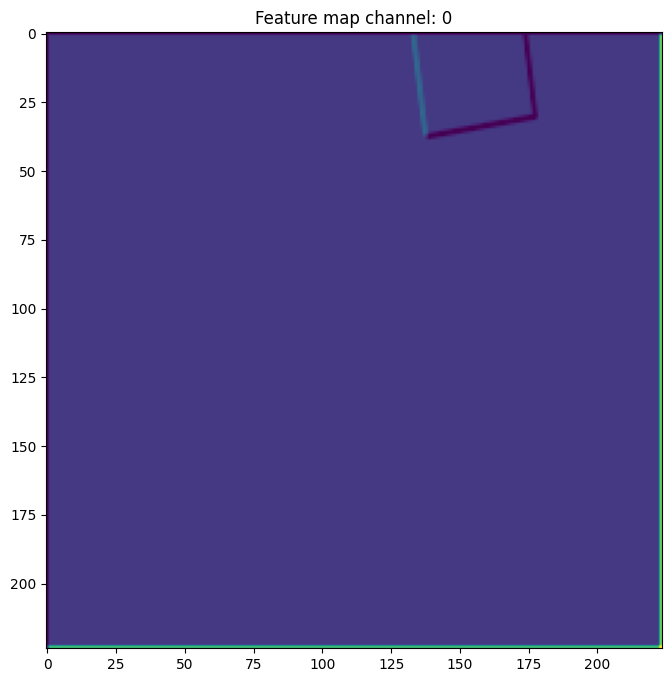

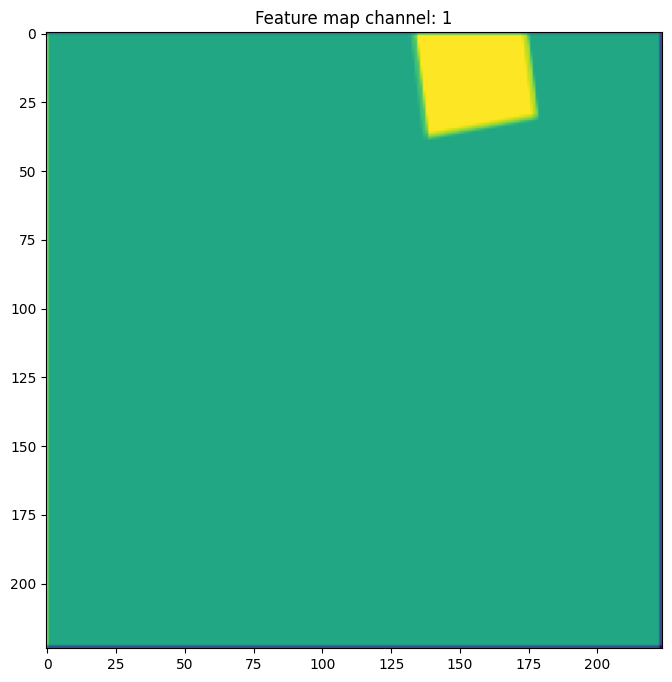

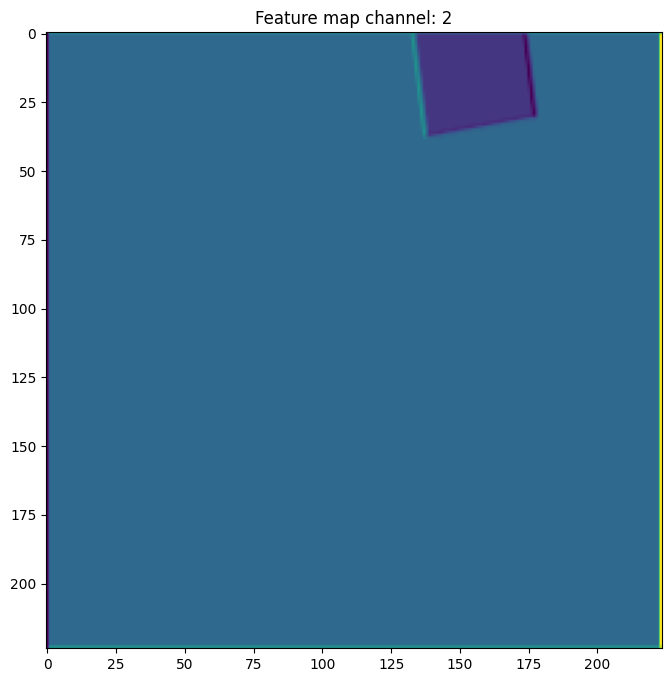

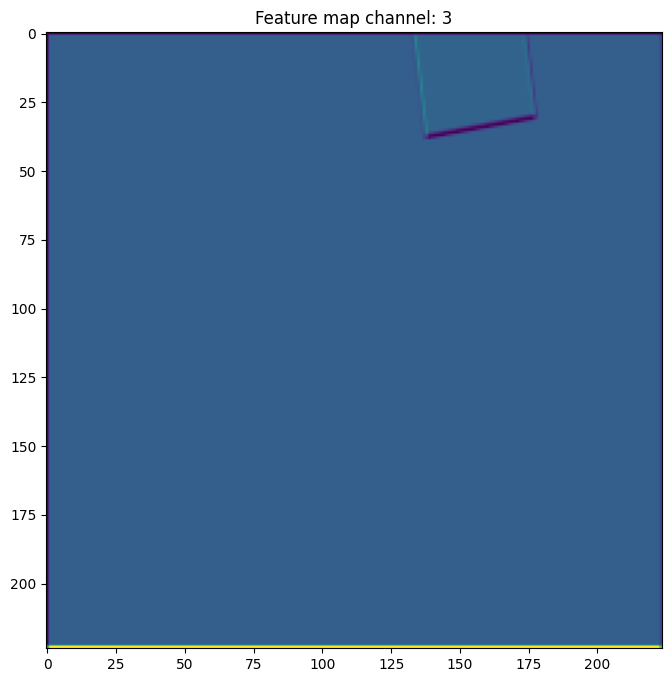

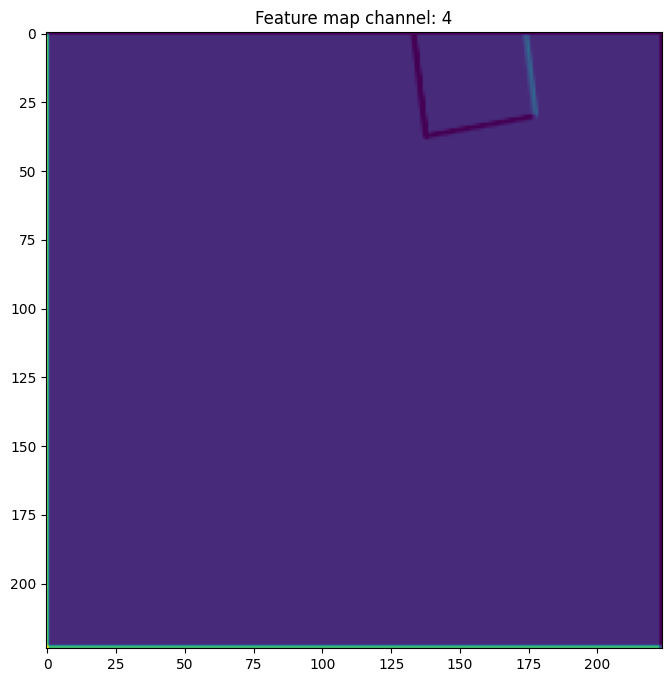

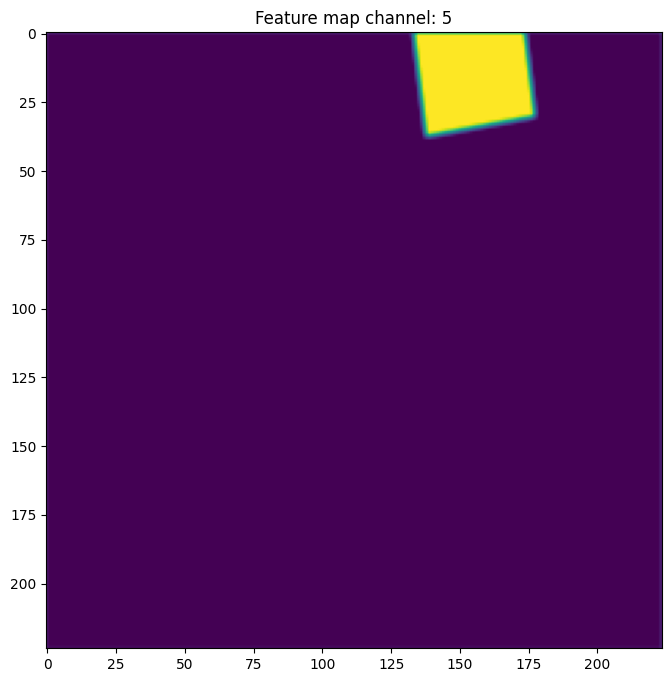

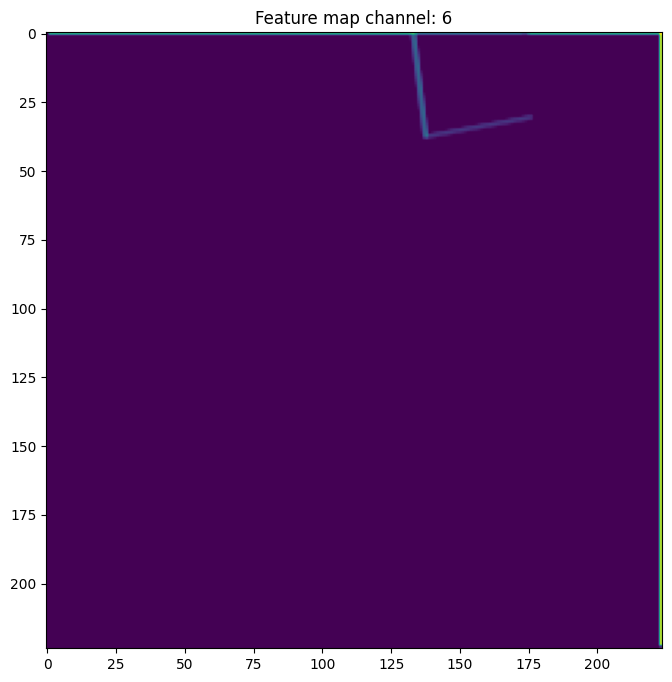

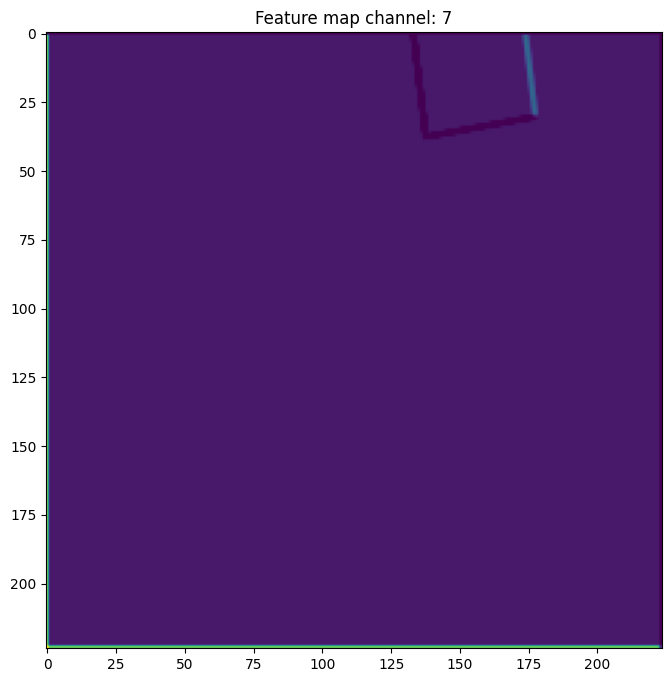

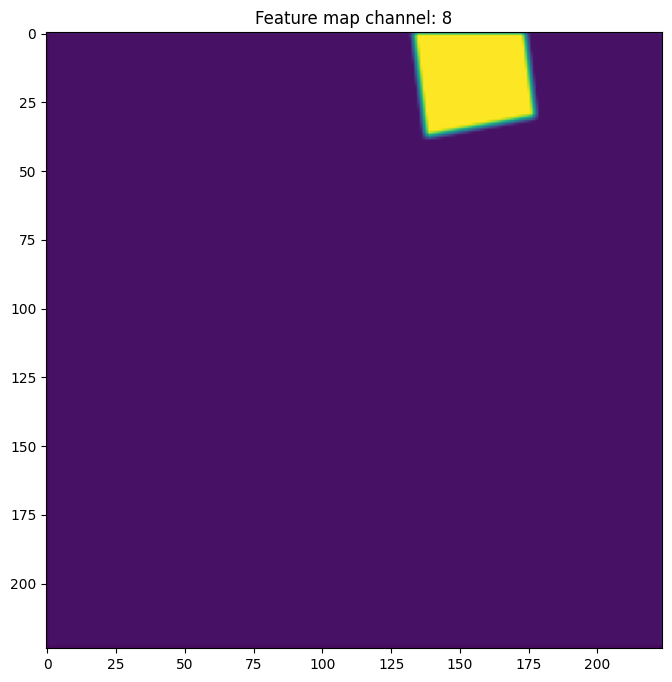

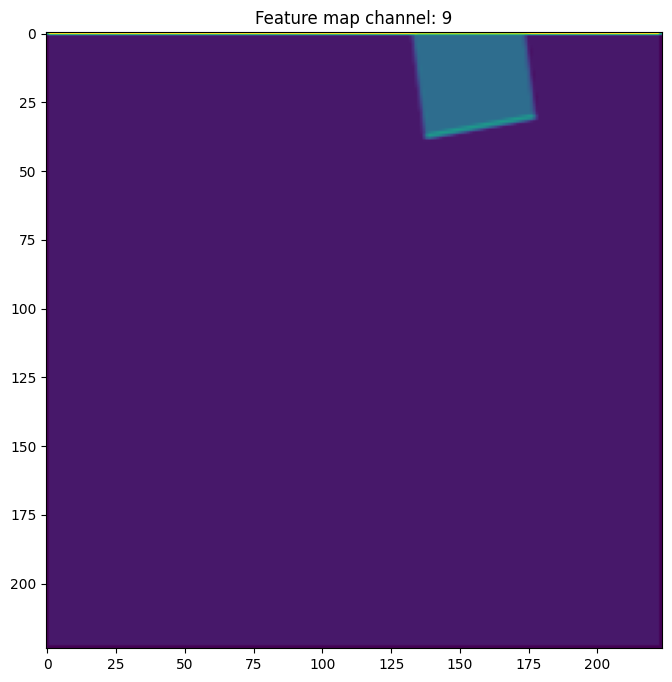

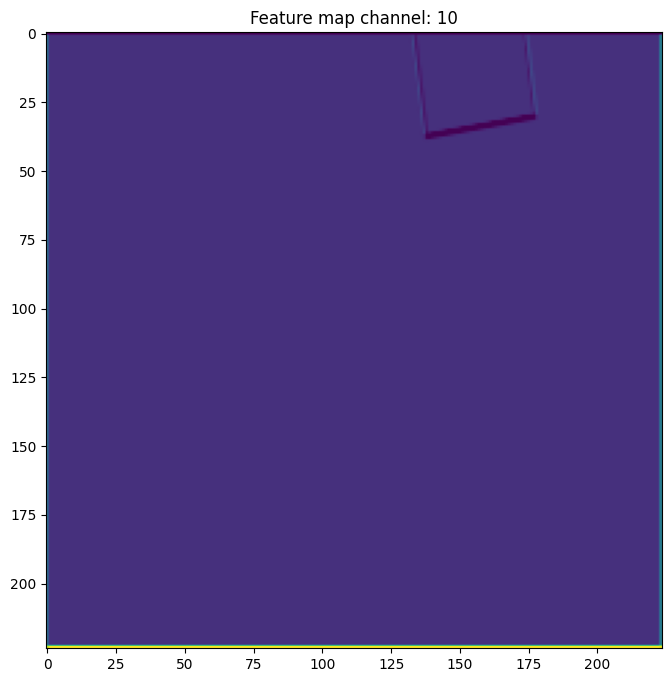

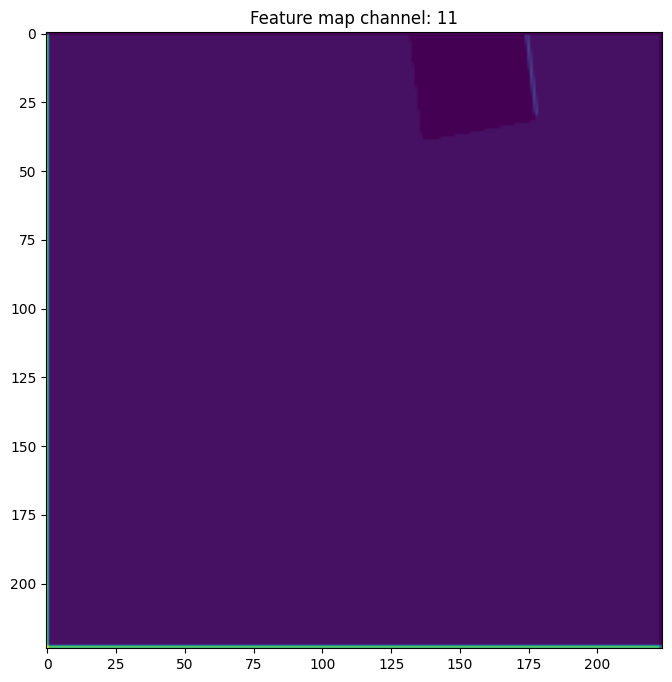

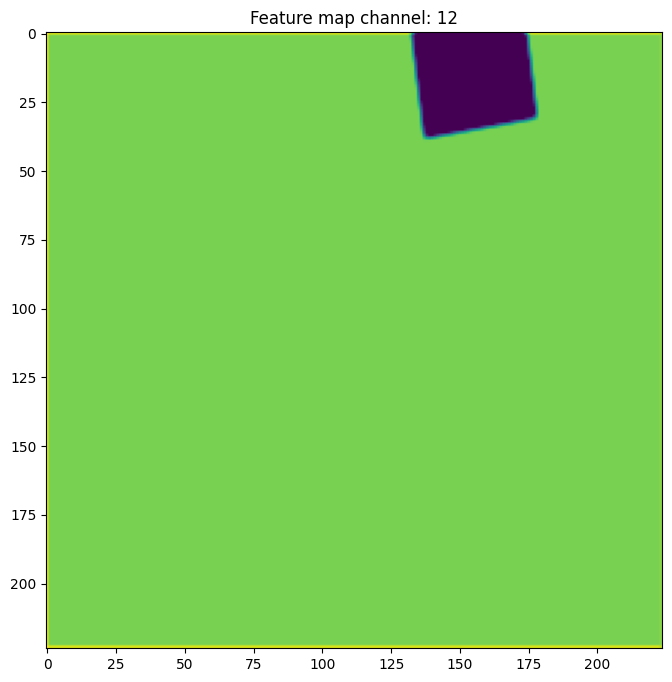

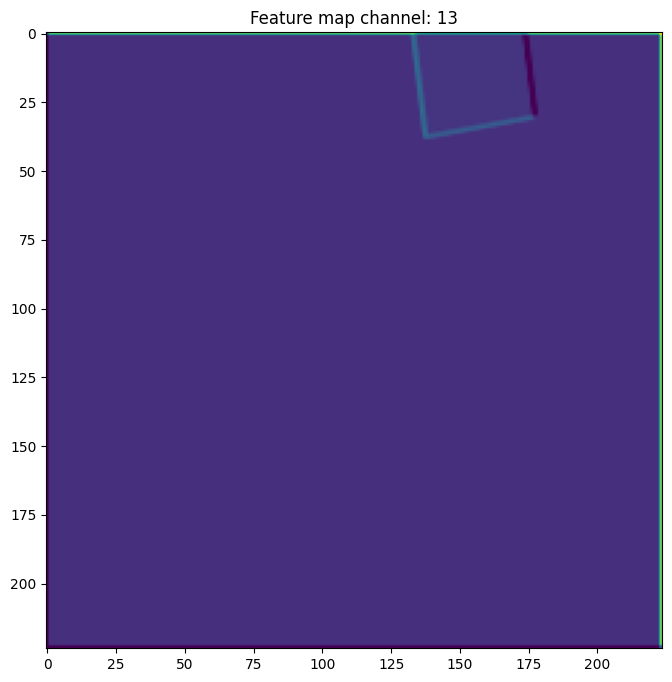

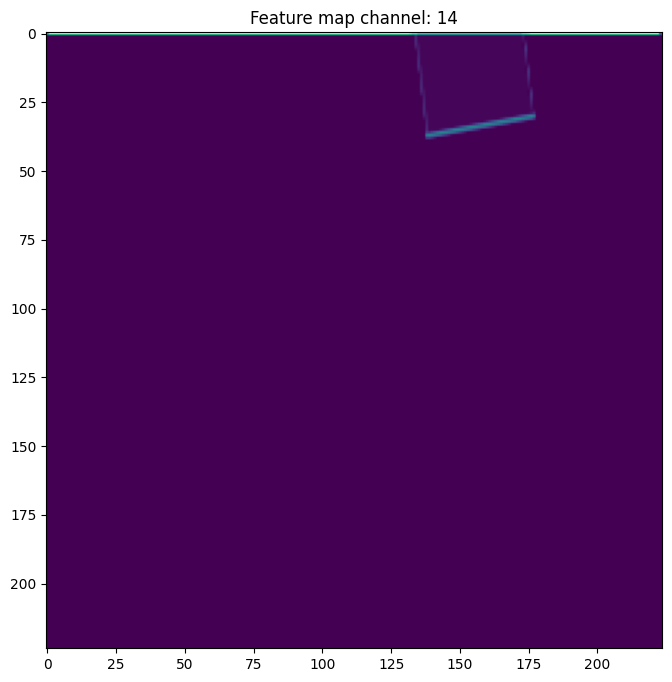

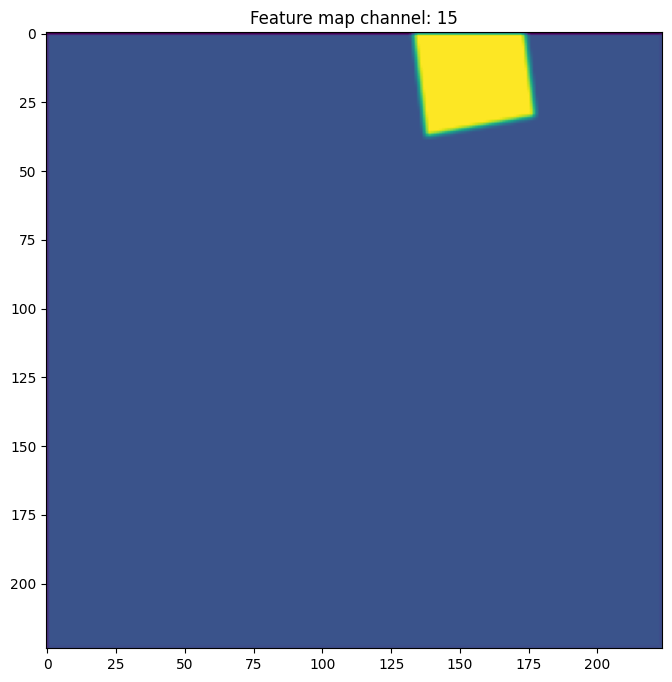

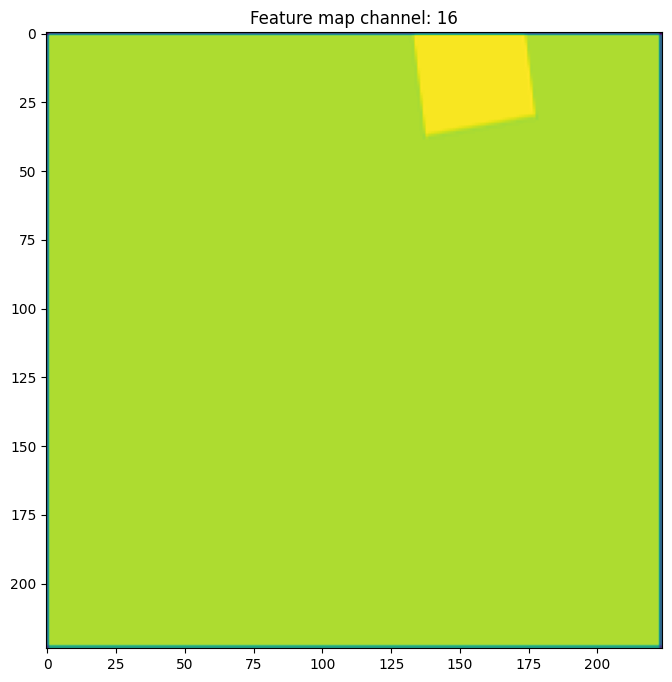

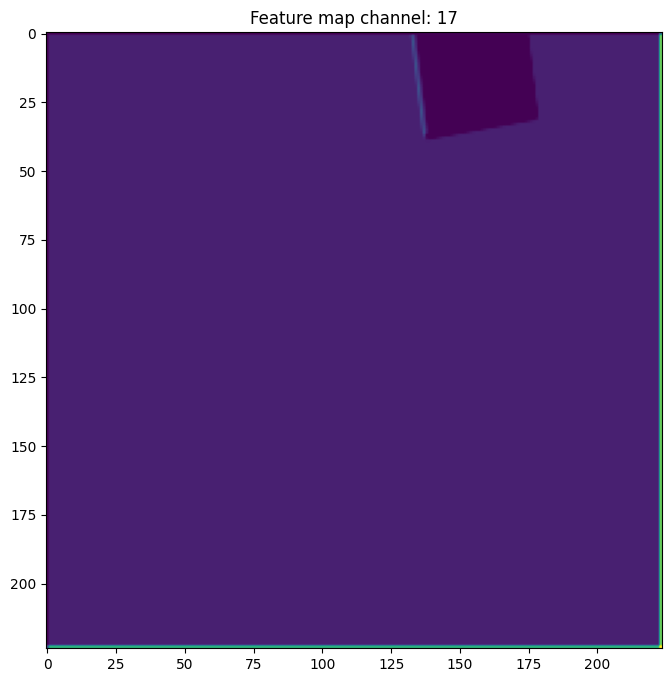

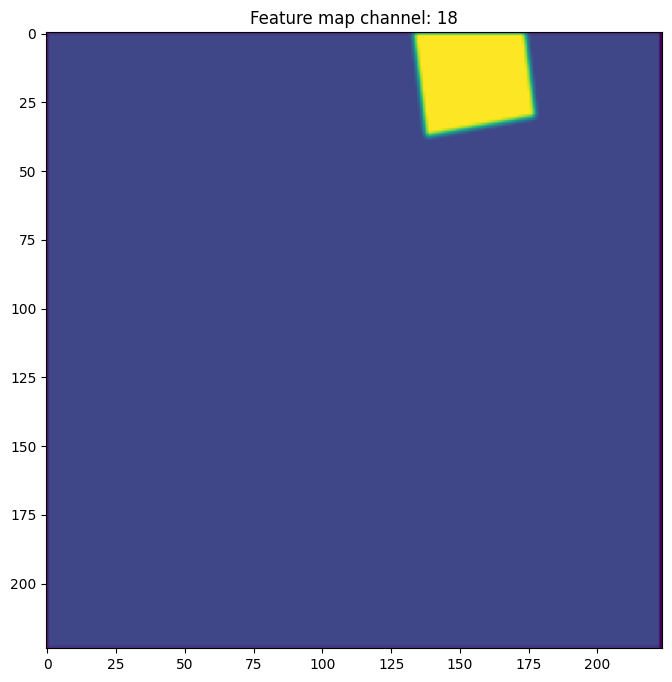

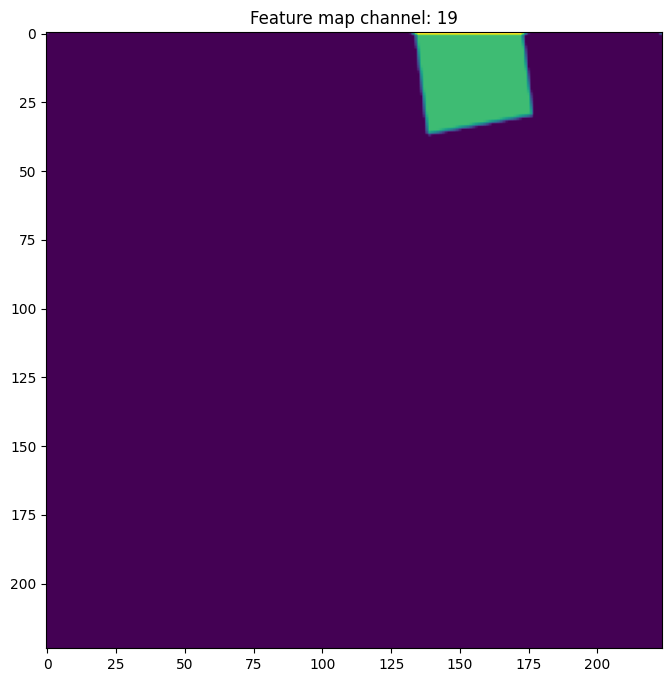

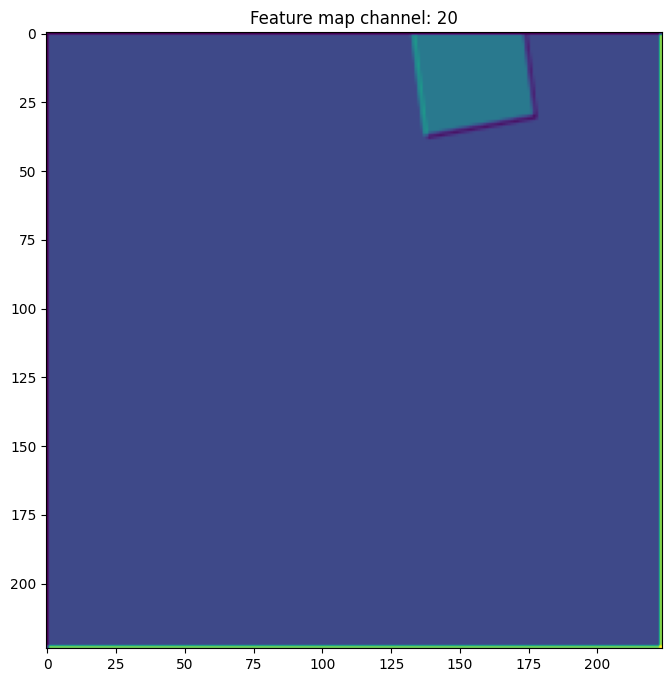

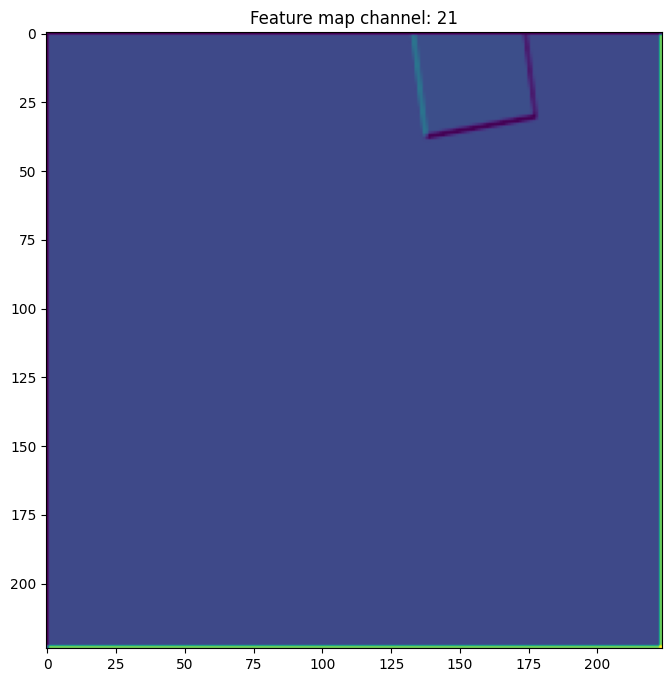

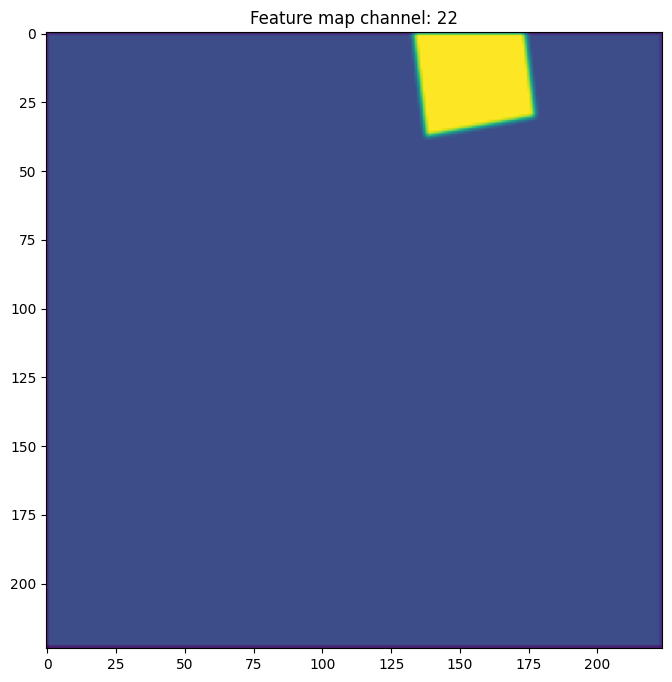

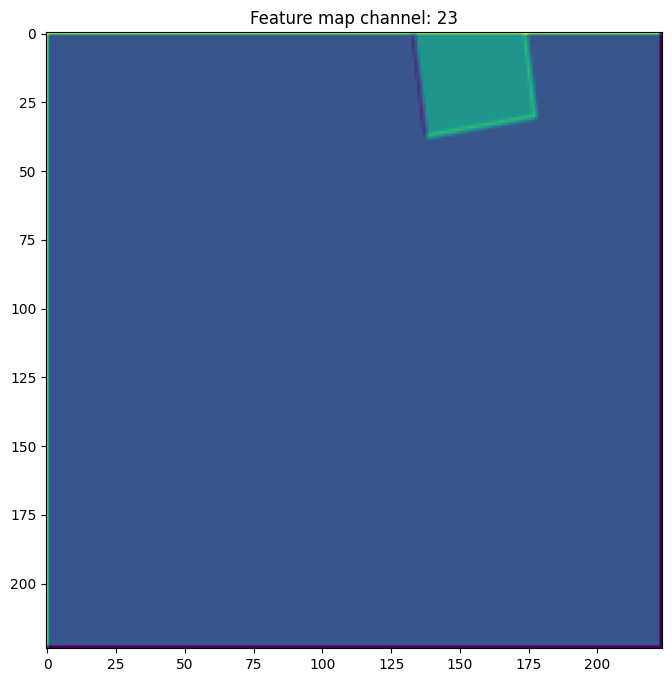

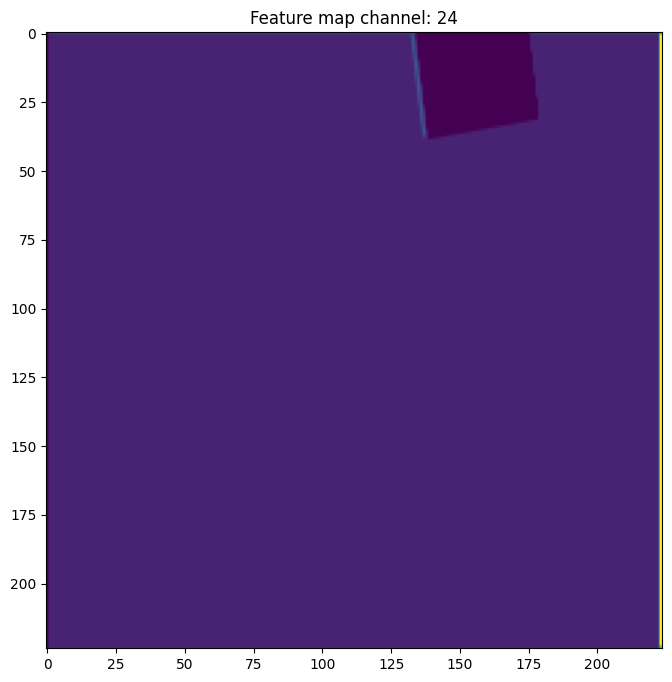

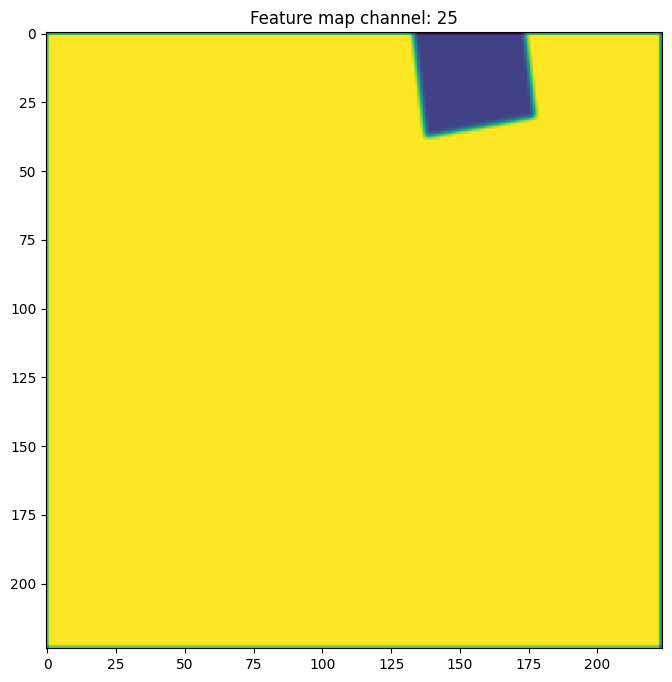

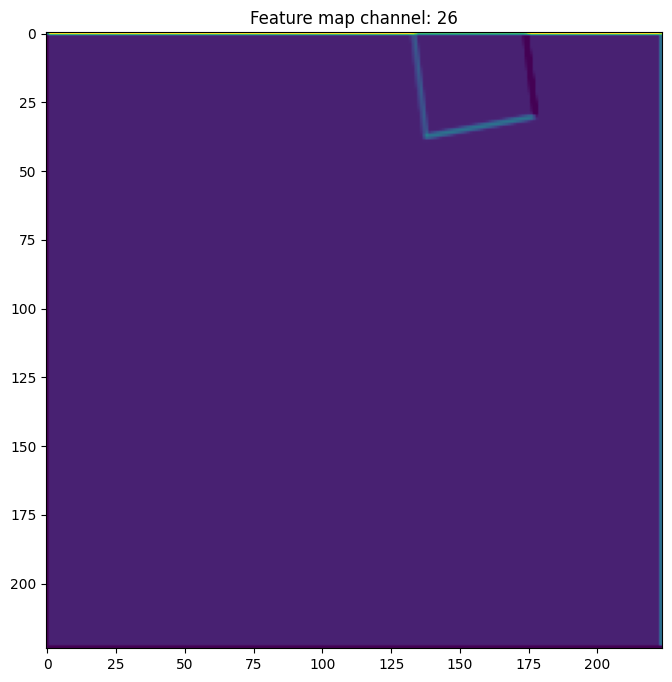

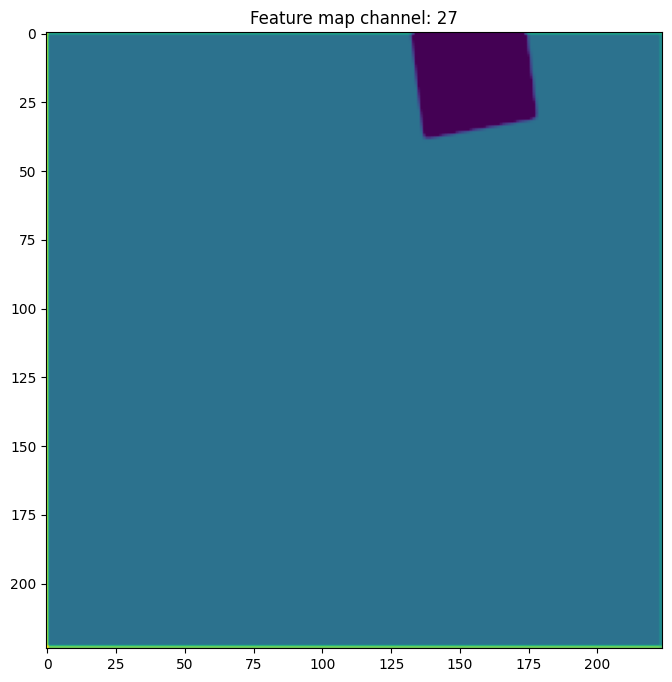

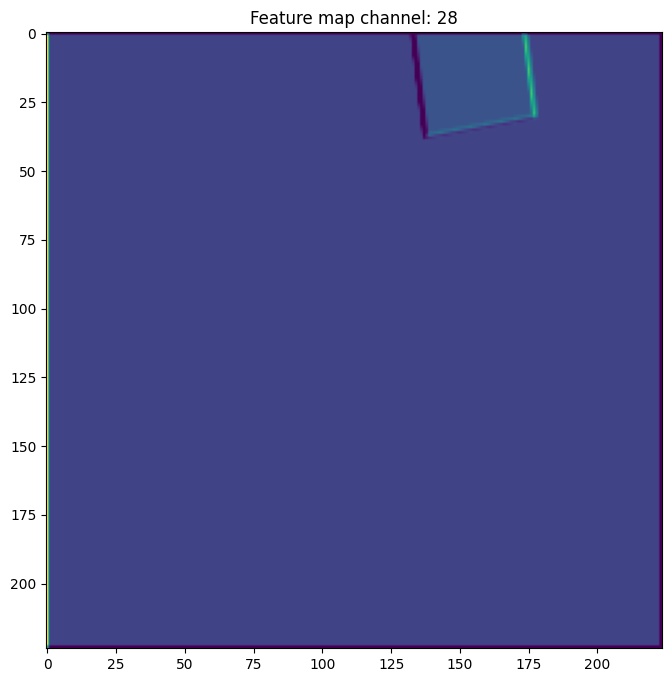

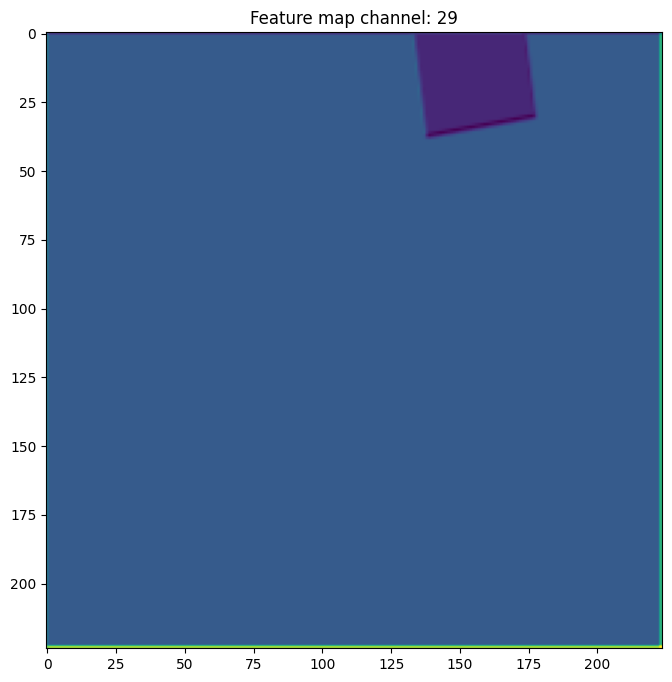

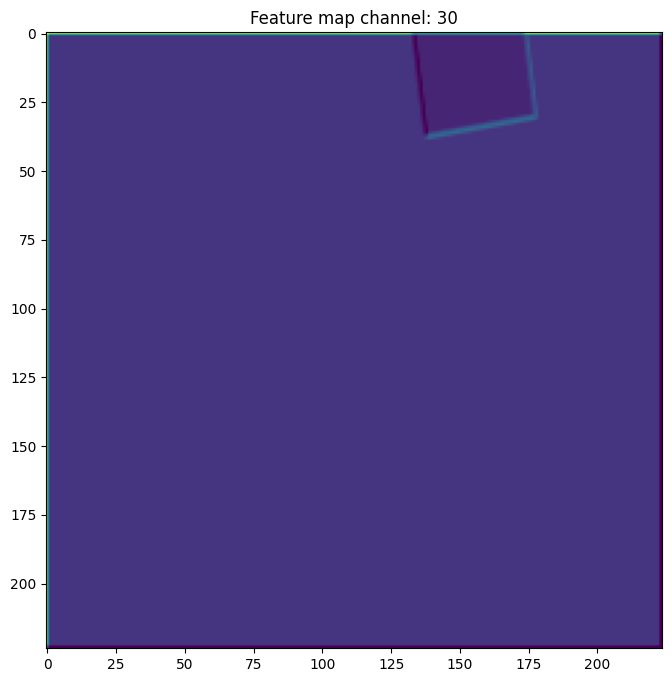

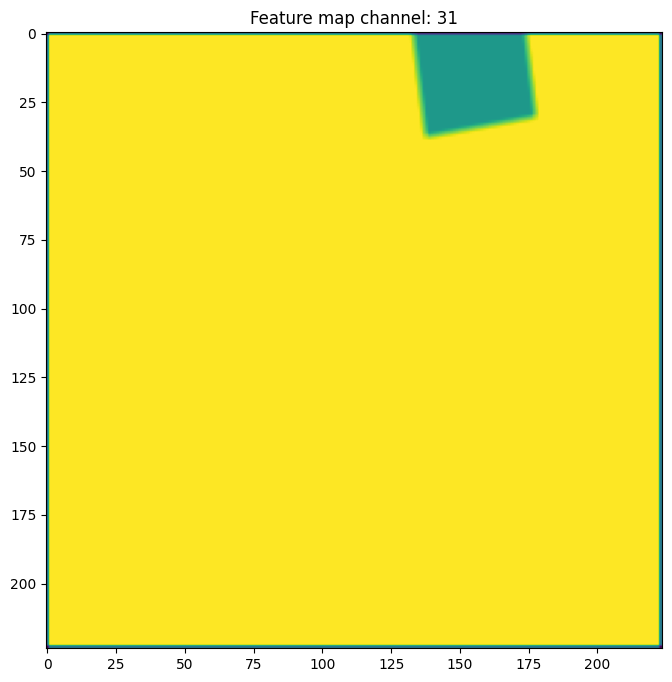

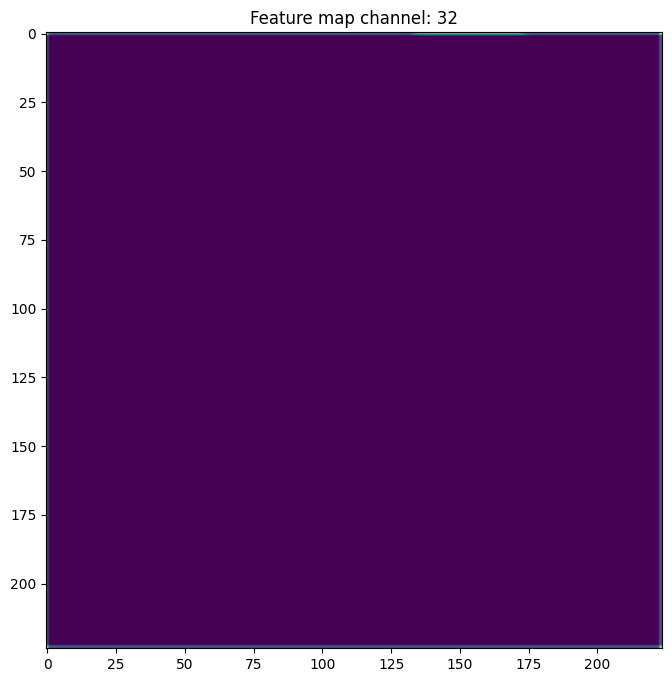

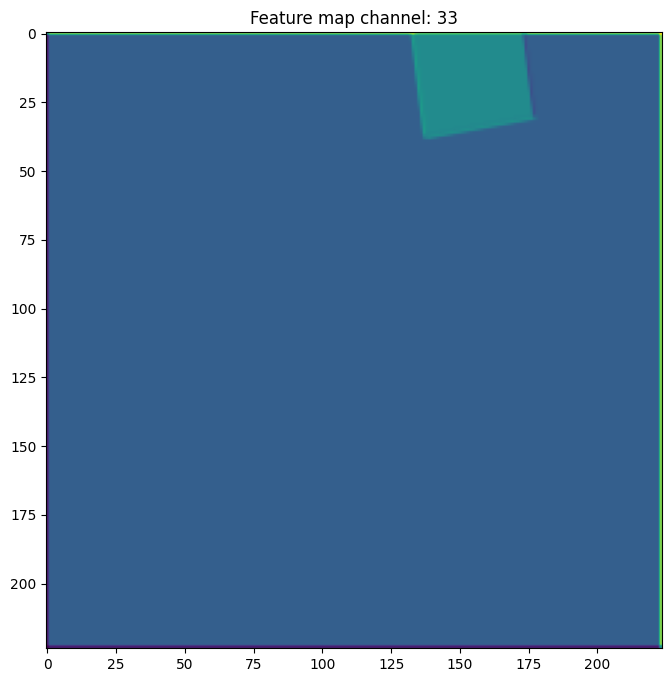

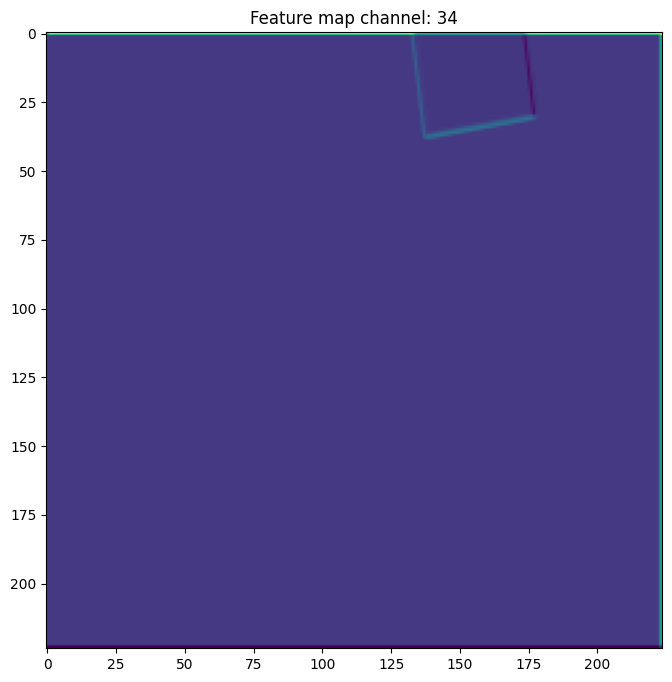

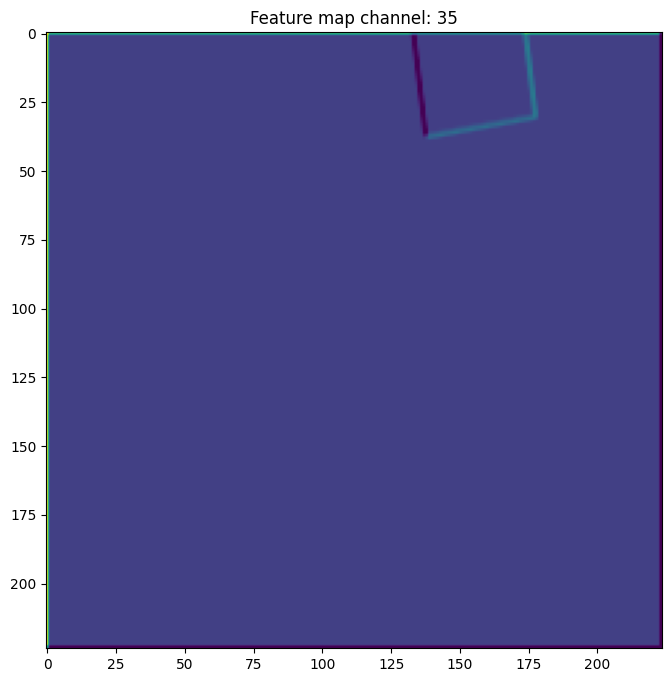

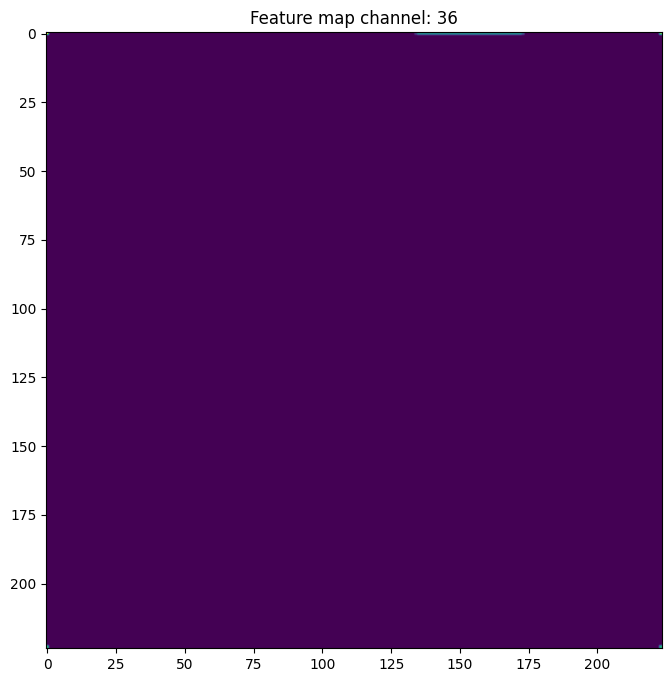

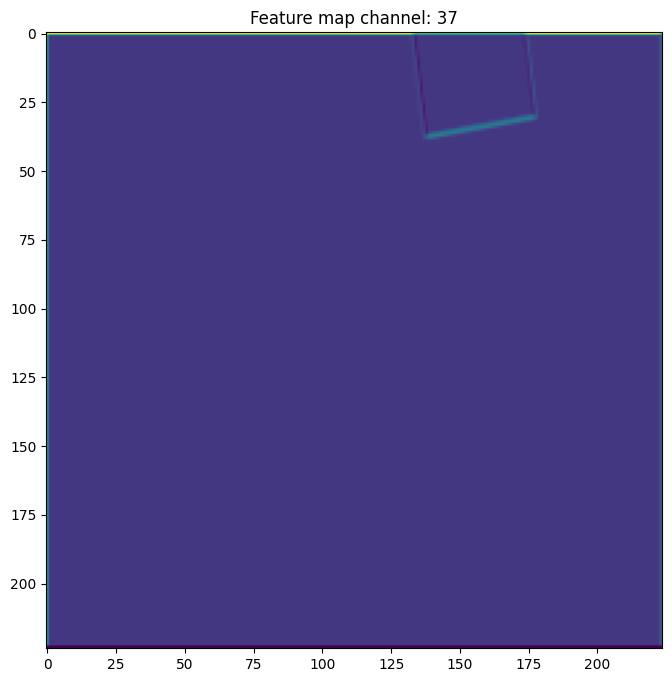

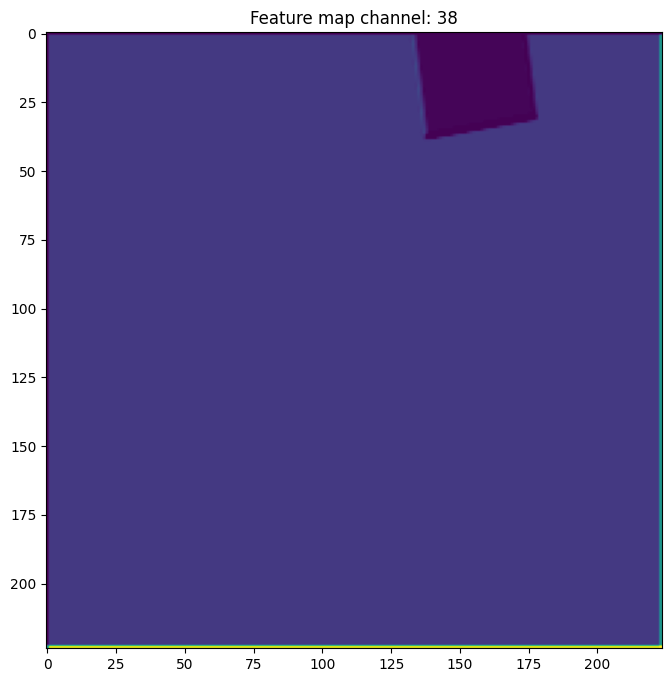

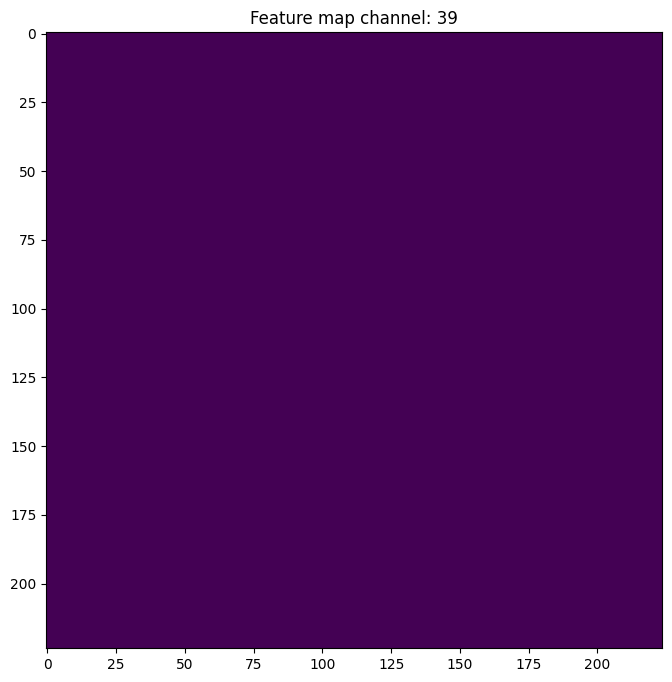

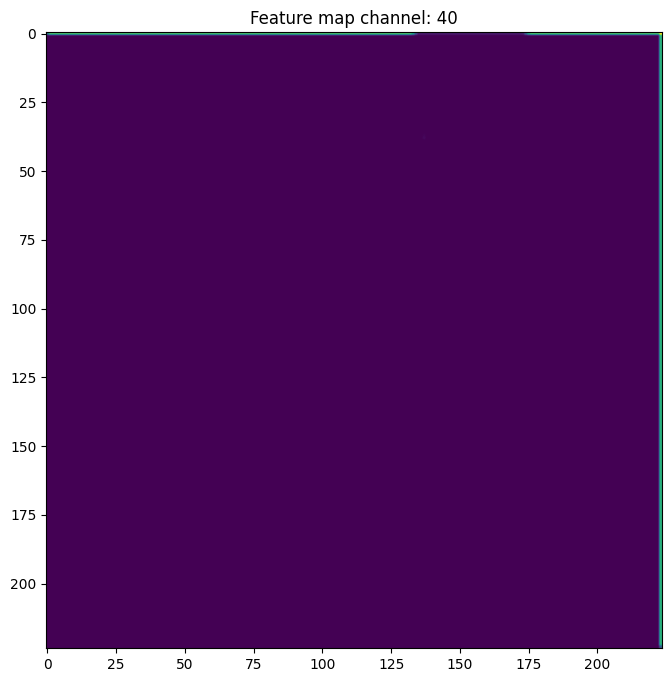

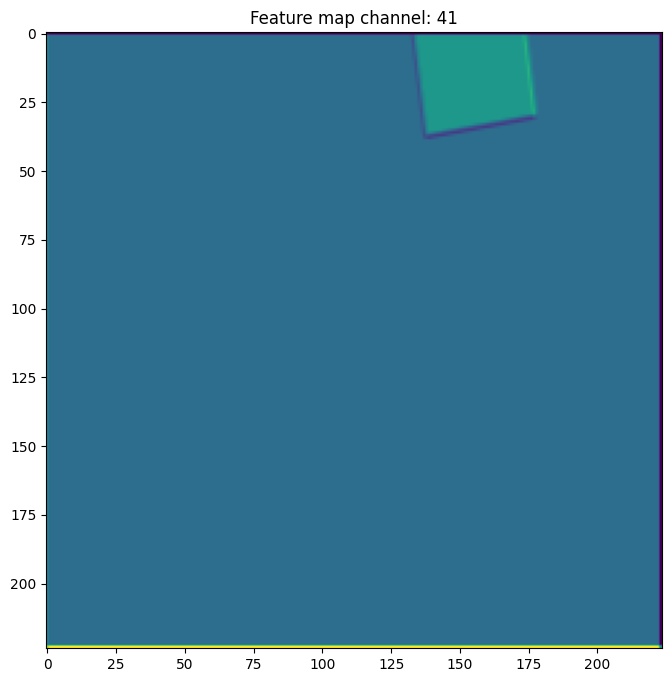

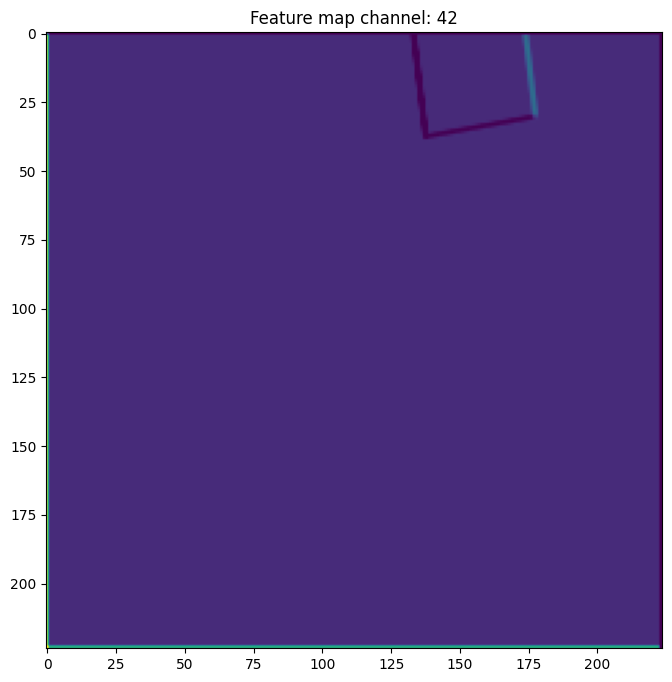

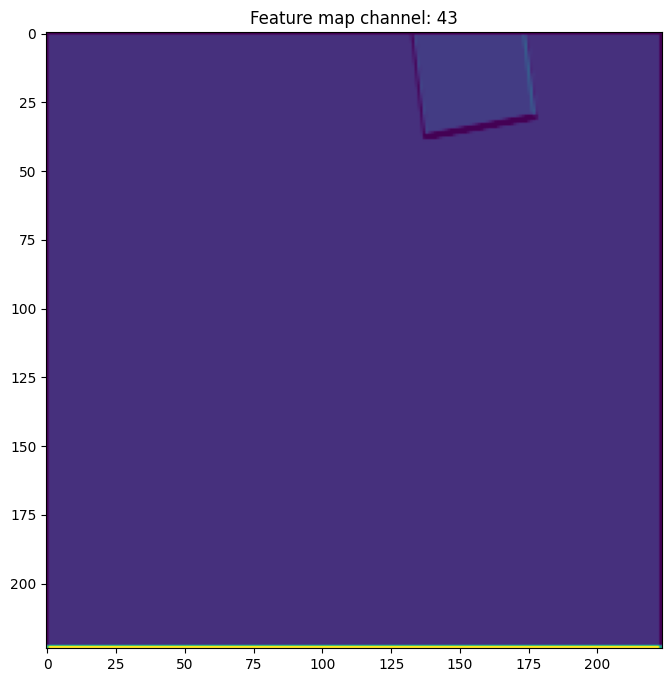

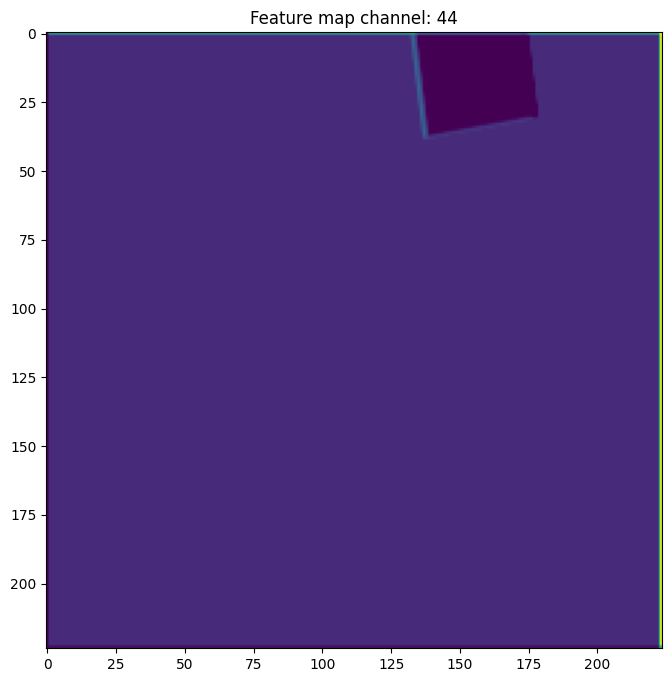

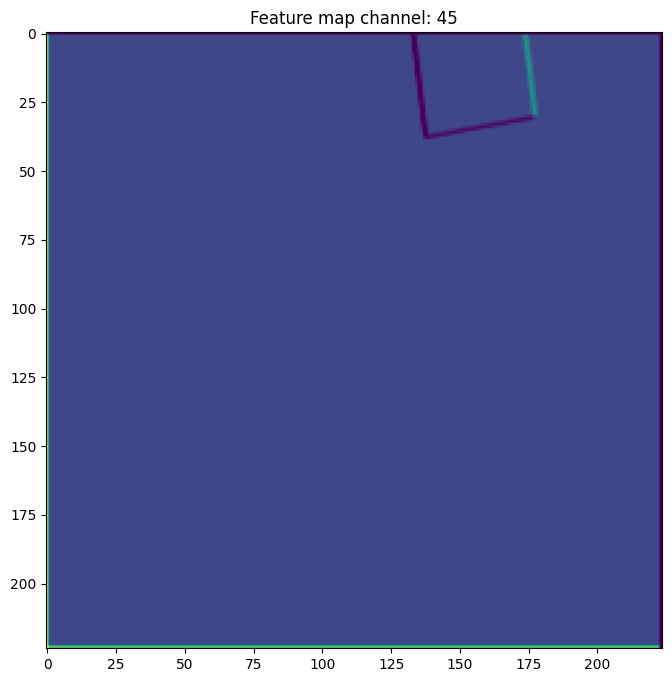

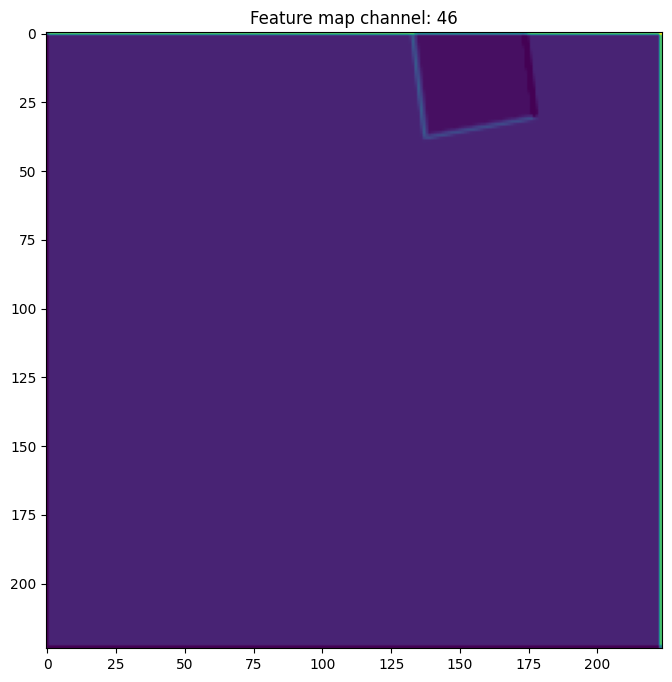

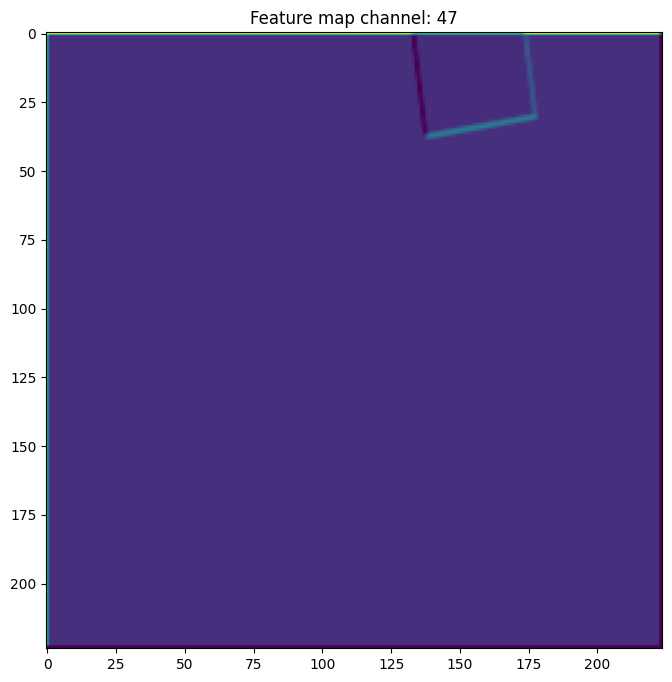

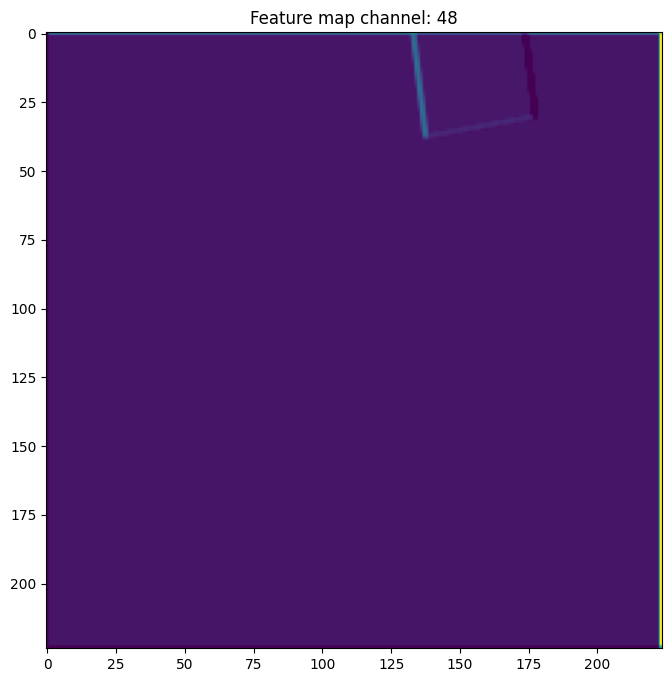

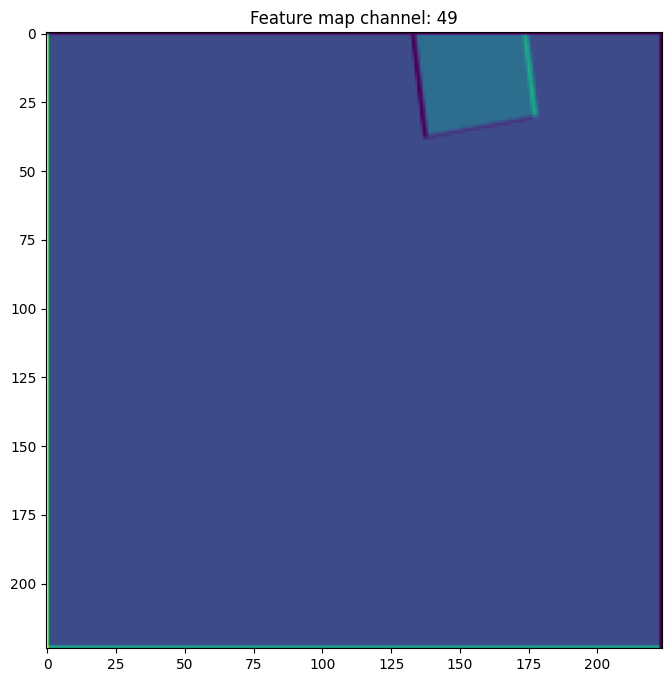

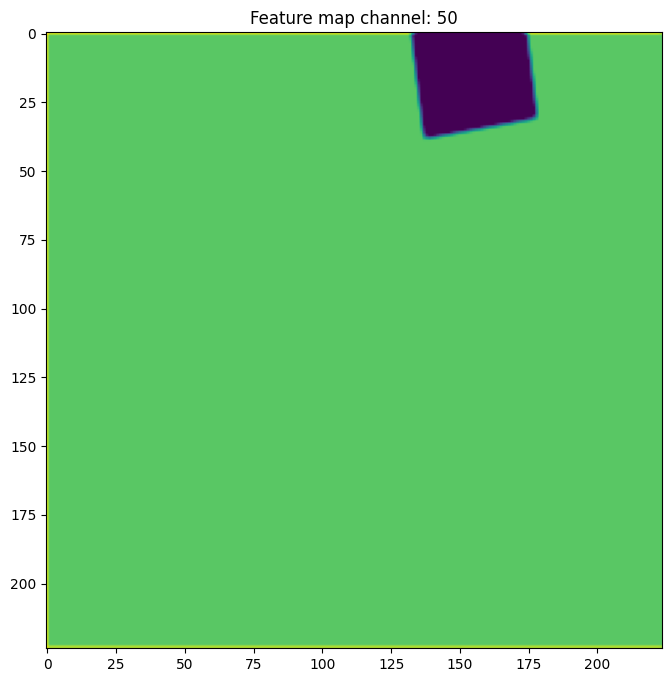

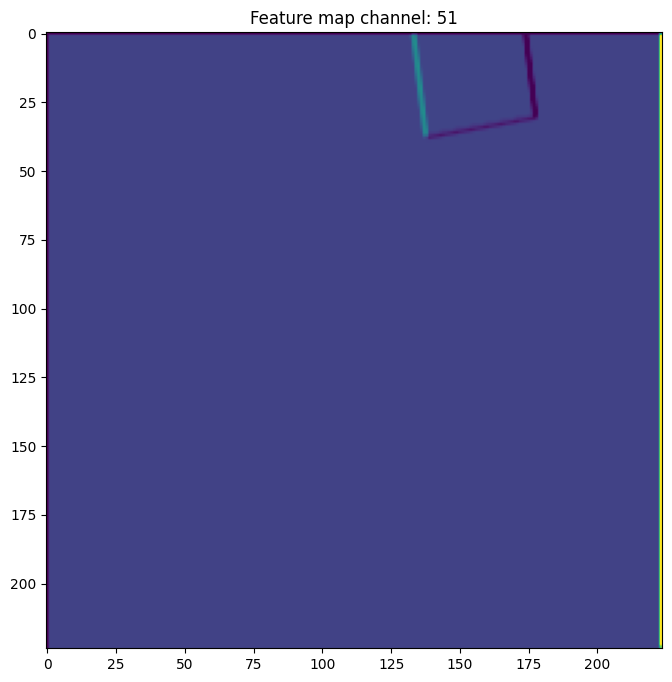

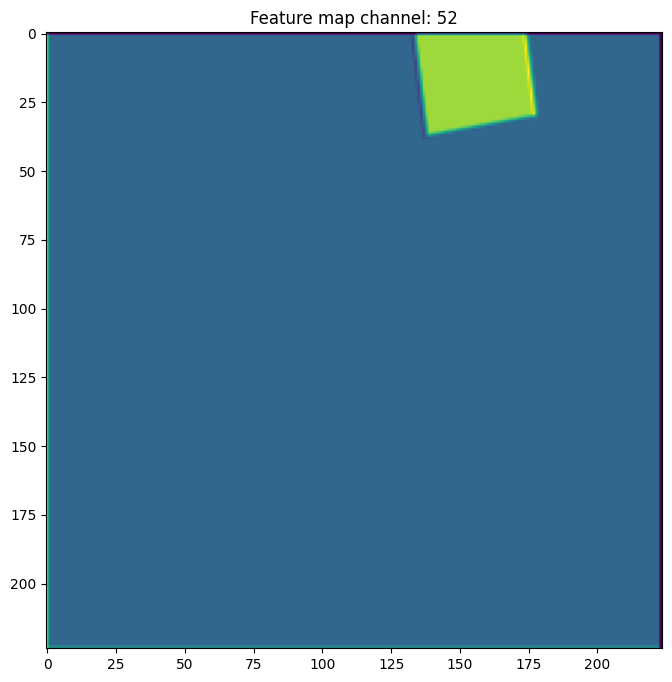

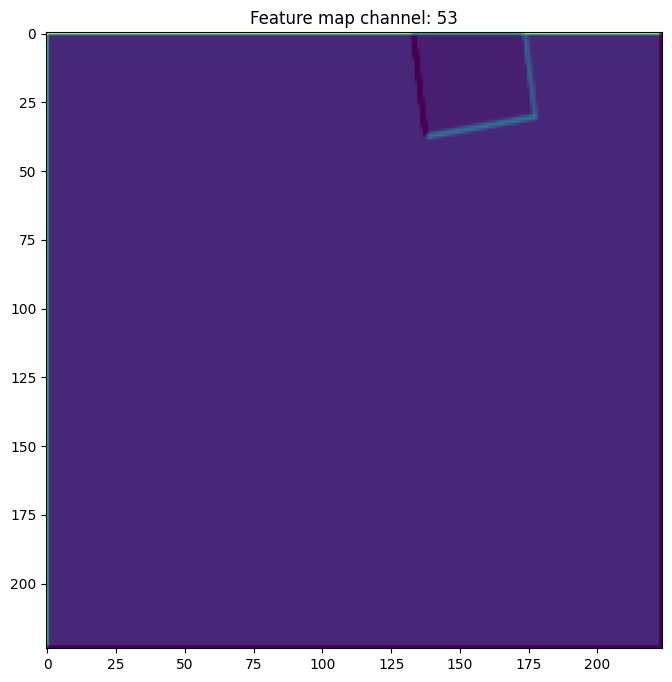

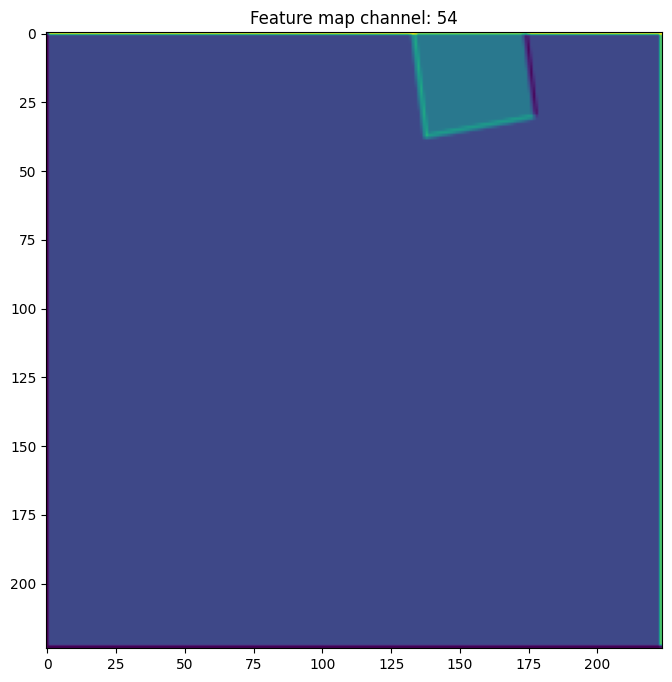

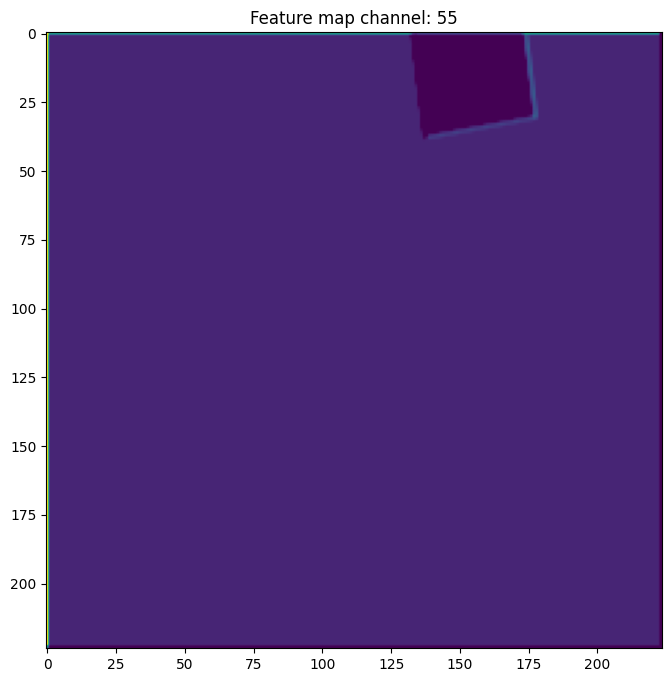

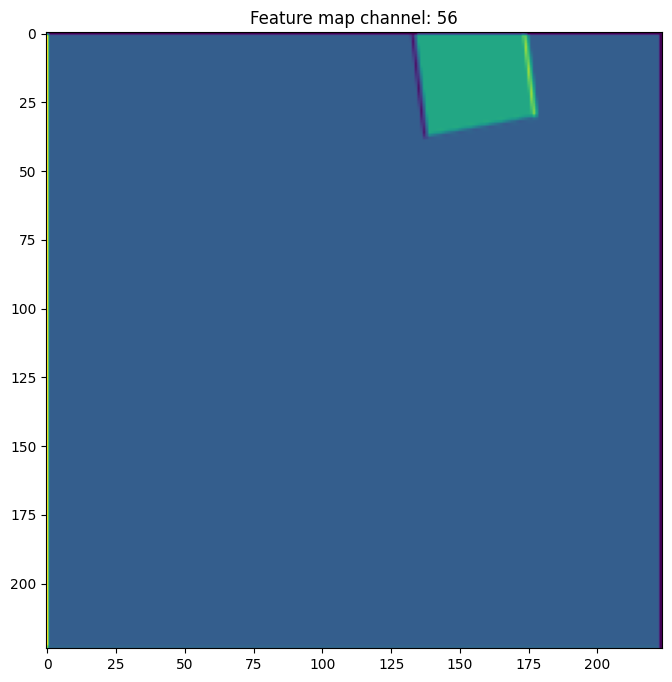

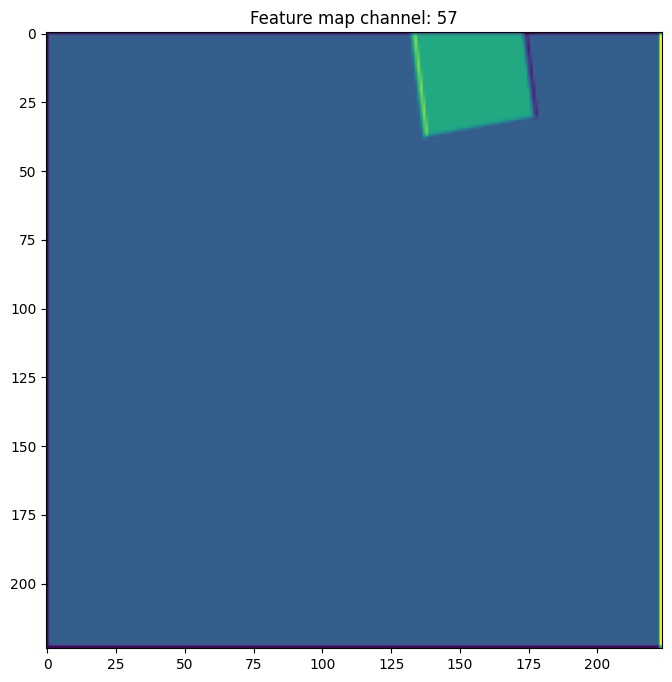

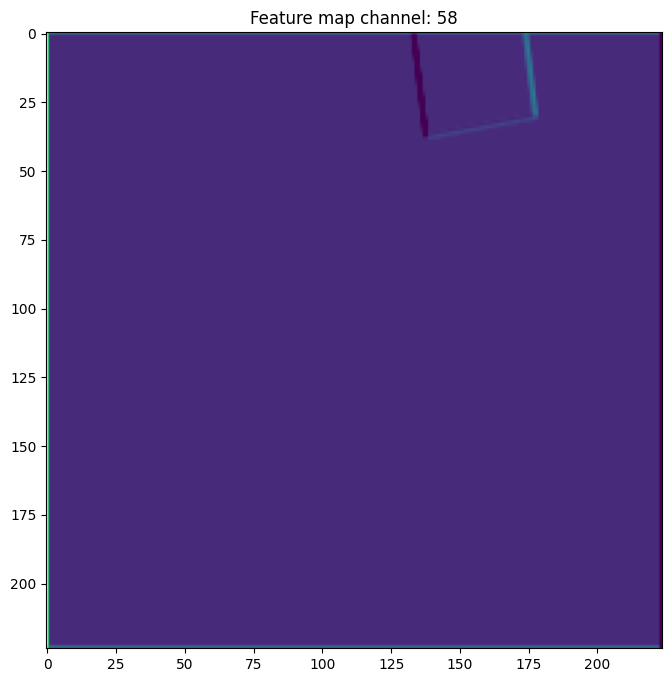

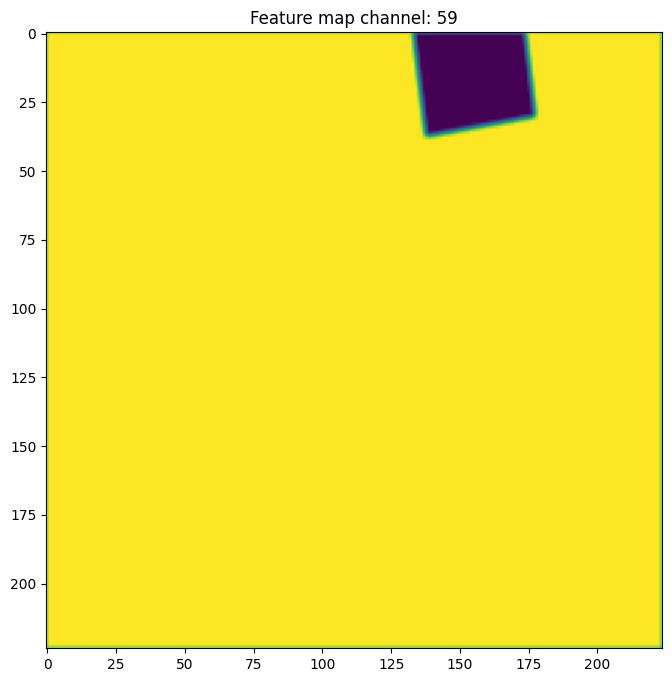

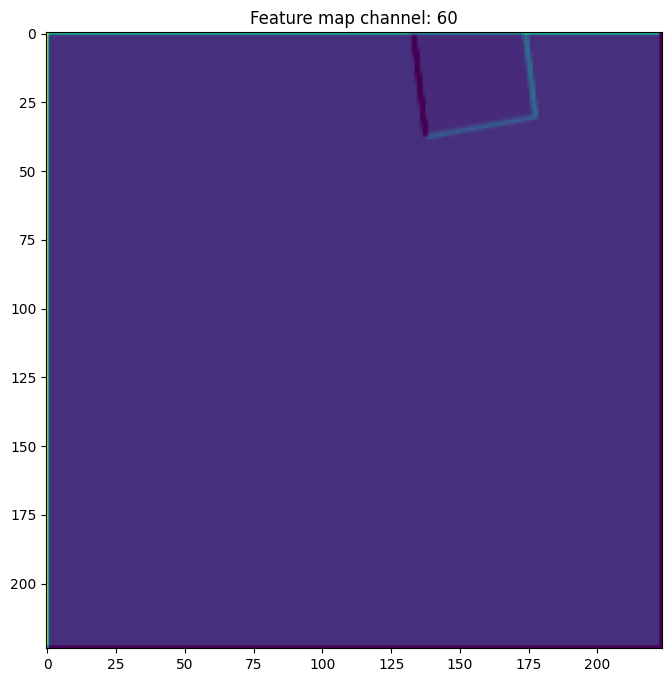

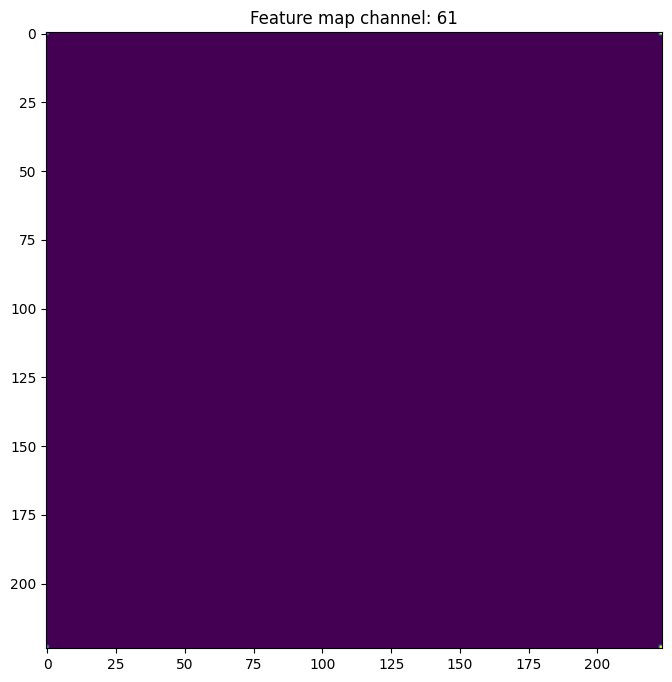

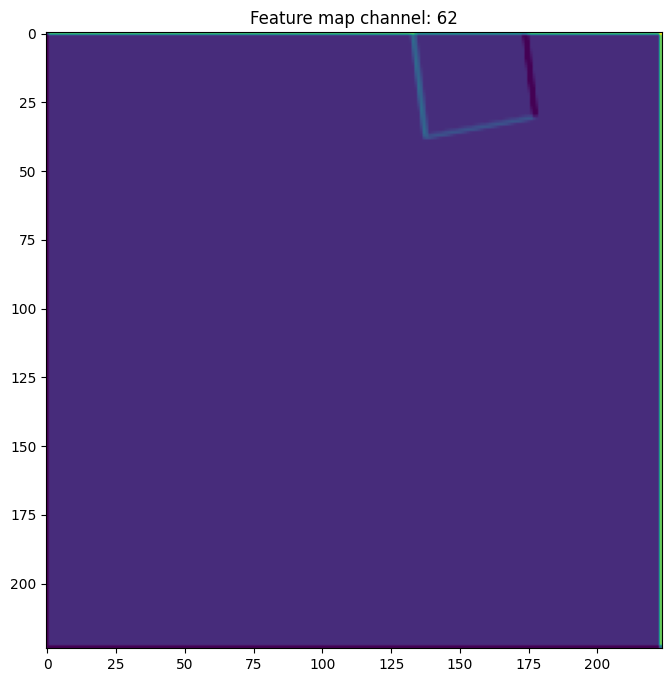

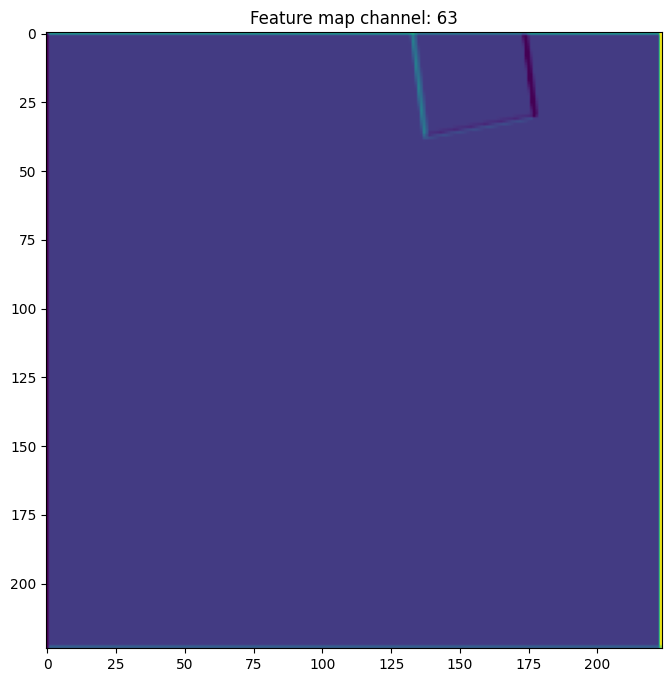

In [7]:
import matplotlib.pyplot as plt

# Define a new model that outputs the feature maps for the first convolutional layer
layer_outputs = [layer.output for layer in base_model.layers if 'conv' in layer.name]  # Grab all the convolutional layers
feature_map_model = keras.models.Model(inputs=base_model.input, outputs=layer_outputs)

# Predict on an image to get the feature maps
img = train_generator[6][0][0]  # Take the first image from the first batch of the training generator
img_tensor = np.expand_dims(img, axis=0)  # The model expects batches, so add an extra dimension
feature_maps = feature_map_model.predict(img_tensor)

# Visualize the feature maps for the first convolutional layer
num_channels = feature_maps[0].shape[-1]
for i in range(num_channels):
    plt.figure(figsize=(8, 8))
    plt.imshow(feature_maps[0][0, :, :, i], cmap='viridis')
    plt.title(f"Feature map channel: {i}")
    plt.show()

